In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from time import  time

from torchvision.utils import make_grid
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST, LSUN

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import random

from bhsgan import DiscriminatorBhsMnist, GeneratorBhsMnist, DiscriminatorBhsLsun, GeneratorBhsLsun
from wgan import GeneratorWassersteinLsun, DiscriminatorWassersteinLsun
from ipmbhsgan import DiscriminatorIpmMnist, GeneratorIpmMnist
from trainer import (Trainer, TrainingParams, get_dis_loss_bhs,
                     get_dis_loss_ipm, get_dis_loss_wasserstein,
                     get_gen_loss_bhs, get_gen_loss_ipm,
                     get_gen_loss_wasserstein)
from utils import get_device, get_noise, init_weights, plot_tensor_images, plot_losses, Positive, save_models_state_dict
from wgan import DiscriminatorWassersteinMnist, GeneratorWassersteinMnist
from torch.utils.tensorboard import SummaryWriter

In [9]:
# create dataloader
batch_size = 1000
device = get_device()
image_size = 64

train_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataloader = DataLoader(
    LSUN('LSUN/bedroom_train_lmdb', classes=['bedroom_train'], transform=train_transform),
    batch_size=batch_size,
    shuffle=True)

In [10]:
device

'cuda:0'

In [19]:
latent_dim = 100
latent_dim_bhs = 64*64
batch_size_bhs = 128
test_noise = torch.reshape(get_noise(25, latent_dim, device), (25, latent_dim, 1, 1))
test_noise_bhs = get_noise(25, latent_dim_bhs, device)

In [12]:
training_params = TrainingParams(lr_dis=0.0002,
                                 lr_gen=0.0002,
                                 num_epochs=1,
                                 num_dis_updates=3,
                                 num_gen_updates=4,
                                 beta_1=0.5,
                                 batch_size=batch_size)

### Wasserstein GAN

In [13]:
save_path_wgan = "WGAN"
generator_wasserstein = GeneratorWassersteinLsun(z_dim=latent_dim).apply(init_weights)
discriminator_wasserstein = DiscriminatorWassersteinLsun().apply(init_weights)
trainer_wgan = Trainer(training_params, generator_wasserstein, discriminator_wasserstein, device=device)

In [14]:
# training loop
trained_wgan = trainer_wgan.train_gan(dataloader, get_dis_loss_wasserstein, get_gen_loss_wasserstein, True, is_color_picture=True)

Epoch 1 start training...
Epoch: 1/1 Total Steps:3034Epoch_Run_Time: 13434.612017	Loss_C : -156.558014	Loss_G : -14118.999268		
Total_Time : 13434.695318
Loss_C : -156.558014
Loss_G : -14118.999268
Loss_C_Mean : -5402.184447
Loss_G_Mean : -187.061765

----------------------------------------------



In [24]:
save_models_state_dict(trained_wgan, save_path_wgan)

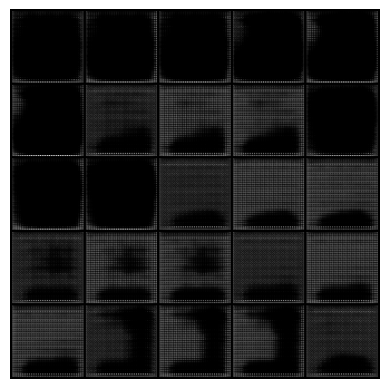

In [22]:
# show generated images
generated_images_wasserstein = trained_wgan.generator(test_noise)
plot_tensor_images(generated_images_wasserstein, num_images=25, size=(1, 64, 64))

In [ ]:
def plot_tensor_images(
    image_tensor, num_images=25, size=(1, 28, 28), save_fig=False, epoch=0
):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.axis("off")
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if save_fig:
        plt.savefig("image_at_epoch_{:04d}.png".format(epoch))

    plt.show()

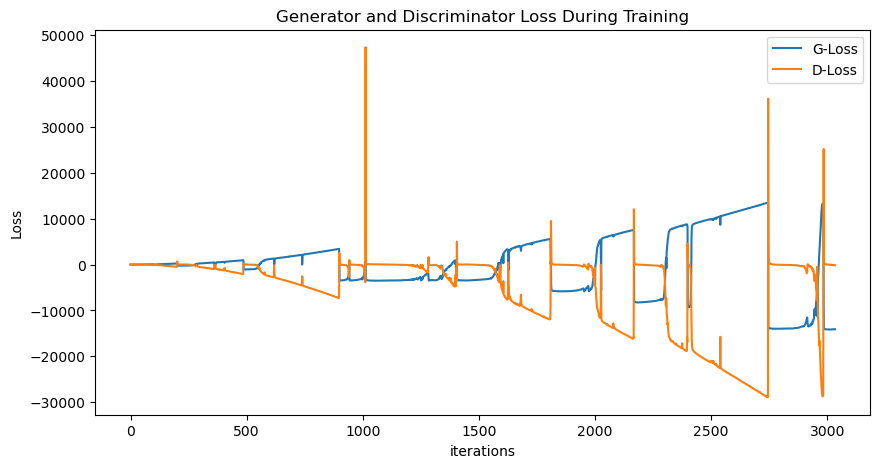

In [23]:
# plot losses
plot_losses(trained_wgan.generator_losses, trained_wgan.discriminator_losses)

### BHS GAN

In [ ]:
save_path_bhsgan = "BHSGAN"
final_activation = Positive
generator_bhs = GeneratorBhsLsun(z_dim=latent_dim).apply(init_weights)
discriminator_bhs = DiscriminatorBhsLsun(final_activation).apply(init_weights)
trainer_bhsgan = Trainer(training_params, generator_wasserstein, discriminator_wasserstein, device=device)

In [ ]:
# training loop
trained_bhsgan = trainer_bhsgan.train_gan(dataloader, get_dis_loss_bhs, get_gen_loss_bhs, False, is_color_picture=True)

In [ ]:
save_models_state_dict(trained_bhsgan, save_path_bhsgan)

In [ ]:
# show generated images
generated_images_bhs = trained_bhsgan.generator(test_noise)
plot_tensor_images(generated_images_bhs, num_images=25)

In [ ]:
# plot losses
plot_losses(trained_bhsgan.generator_losses, trained_bhsgan.discriminator_losses)

## KL GAN

In [ ]:
save_path_bhsgan = "KLGAN"
final_activation = nn.Identity
generator_kl = GeneratorBhsLsun(z_dim=latent_dim).apply(init_weights)
discriminator_kl = DiscriminatorBhsLsun(final_activation).apply(init_weights)
trainer_klgan = Trainer(training_params, generator_kl, discriminator_kl, device=device)

In [ ]:
# training loop
trained_klgan = trainer_klgan.train_gan(dataloader, get_dis_loss_kl, get_gen_loss_kl, False, is_color_picture=True)

In [ ]:
save_models_state_dict(trained_klgan, save_path_klgan)

In [ ]:
# show generated images
generated_images_kl = trained_klgan.generator(test_noise)
plot_tensor_images(generated_images_kl, num_images=25)

In [ ]:
# plot losses
plot_losses(trained_klgan.generator_losses, trained_klgan.discriminator_losses)

### RV KL GAN

In [ ]:
save_path_bhsgan = "RVKLGAN"
final_activation = RevKlActivation
generator_rvkl = GeneratorBhsLsun(z_dim=latent_dim).apply(init_weights)
discriminator_rvkl = DiscriminatorBhsLsun(final_activation).apply(init_weights)
trainer_rvklgan = Trainer(training_params, generator_rvkl, discriminator_rvkl, device=device)

In [ ]:
# training loop
trained_rvklgan = trainer_rvklgan.train_gan(dataloader, get_dis_loss_rvkl, get_gen_loss_rvkl, False, is_color_picture=True)

In [ ]:
save_models_state_dict(trained_rvklgan, save_path_rvklgan)

In [ ]:
# show generated images
generated_images_rvkl = trained_bhsgan.generator(test_noise)
plot_tensor_images(generated_images_rvkl, num_images=25)

In [ ]:
# plot losses
plot_losses(trained_rvklgan.generator_losses, trained_rvklgan.discriminator_losses)

### Standard GAN

In [ ]:
save_path_bhsgan = "GAN"
final_activation = GanGanActivation
generator_gan = GeneratorBhsLsun(z_dim=latent_dim).apply(init_weights)
discriminator_gan = DiscriminatorBhsLsun(final_activation).apply(init_weights)
trainer_gan = Trainer(training_params, generator_gan, discriminator_gan, device=device)

In [ ]:
# training loop
trained_gan = trainer_gan.train_gan(dataloader, get_dis_loss_gan, get_gen_loss_gan, False, is_color_picture=True)

In [ ]:
save_models_state_dict(trained_gan, save_path_gan)

In [ ]:
# show generated images
generated_images_gan = trained_gan.generator(test_noise)
plot_tensor_images(generated_images_gan, num_images=25)

In [ ]:
# plot losses
plot_losses(trained_gan.generator_losses, trained_gan.discriminator_losses)

### Pearson GAN

In [ ]:
save_path_pearsongan = "PEARSONGAN"
final_activation = nn.Identity
generator_pearson = GeneratorBhsLsun(z_dim=latent_dim).apply(init_weights)
discriminator_pearson = DiscriminatorBhsLsun(final_activation).apply(init_weights)
trainer_pearsongan = Trainer(training_params, generator_pearson, discriminator_pearson, device=device)

In [ ]:
# training loop
trained_pearsongan = trainer_pearsongan.train_gan(dataloader, get_dis_loss_p, get_gen_loss_p, False, is_color_picture=True)

In [ ]:
save_models_state_dict(trained_pearsongan, save_path_pearsongan)

In [ ]:
# show generated images
generated_images_pearson = trained_pearsongan.generator(test_noise)
plot_tensor_images(generated_images_pearson, num_images=25)

In [ ]:
# plot losses
plot_losses(trained_pearsongan.generator_losses, trained_pearsongan.discriminator_losses)